In [8]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
from scipy.integrate import quad
from scipy.stats import lognorm

import sys
sys.path.append('/home/jianjun/quantum-finance/')

# Vanilla Call options

$payoff(x) = \max(x-\kappa, 0)$

In [9]:
# number of qubits to represent the uncertainty for our probability distribution
num_uncertainty_qubits = 4

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

scale = np.exp(mu) 

def call_payoff(S_T, K, r, T):
    return np.exp(-r * T) * max(S_T - K, 0)

strike_price = 1.9
# Integrating the call payoff function against the lognormal PDF from K to infinity
continuous_expected_value, _ = quad(lambda S_T: call_payoff(S_T, strike_price, r, T) * lognorm.pdf(S_T, s=sigma, scale=scale), strike_price, np.inf)

payoff = np.maximum(uncertainty_model.values - strike_price, 0)
discrete_expected_value = np.dot(uncertainty_model.probabilities, payoff)
print("mu: ", mu)
print("sigma: ", sigma)
print("mean: ", mean)
print("variance: ", variance)

print("Exact value:     \t{}".format(continuous_expected_value))
print("Discrete value: \t{}".format(discrete_expected_value))
print("Relative error:  \t{} %".format(((1 - discrete_expected_value / continuous_expected_value)*100)))

mu:  0.6898595093270685
sigma:  0.13241694217637887
mean:  2.0109889834186916
variance:  0.07153516268792603
Exact value:     	0.16713122937760178
Discrete value: 	0.16603094422320053
Relative error:  	0.6583360623258261 %


Text(0.5, 0, 'Strike Price')

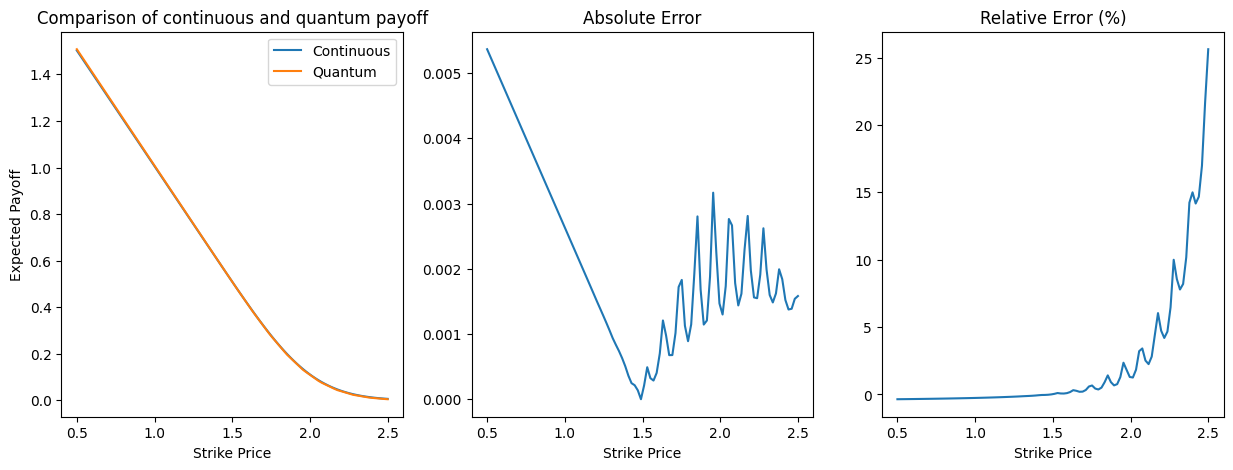

In [10]:
strike_prices = np.linspace(0.5, 2.5, 100)
exact_values = [quad(lambda S_T: call_payoff(S_T, K, r, T) * lognorm.pdf(S_T, s=sigma, scale=scale), K, np.inf)[0] for K in strike_prices]
discrete_values = [np.dot(uncertainty_model.probabilities, np.maximum(uncertainty_model.values - K, 0)) for K in strike_prices]

absolute_errors = [np.abs(exact_values[i] - discrete_values[i]) for i in range(len(strike_prices))]
relative_errors = [(1 - discrete_values[i] / exact_values[i])*100 for i in range(len(strike_prices))]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].plot(strike_prices, exact_values, label='Continuous')
ax[0].plot(strike_prices, discrete_values, label='Quantum')
ax[0].set_title('Comparison of continuous and quantum payoff')
ax[0].set_xlabel('Strike Price')
ax[0].set_ylabel('Expected Payoff')
ax[0].legend()

ax[1].plot(strike_prices, absolute_errors, label='absolute error')
ax[1].set_title('Absolute Error')
ax[1].set_xlabel('Strike Price')

ax[2].plot(strike_prices, relative_errors, label='relative error')
ax[2].set_title('Relative Error (%)')
ax[2].set_xlabel('Strike Price')



# Basket Call
$payoff(x_1, x_2) = \max(x_1+x_2-\kappa, 0)$

In [11]:
import numpy as np
from qfinance.option_pricing import OptionPricing, OptionParams

## define options
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution

# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

strike_price = 1.9

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)


def generate_covariance_matrix(first_var, second_var, correlation=0.5):
    covariance_matrix = np.array(
        [
            [first_var, correlation * np.sqrt(first_var) * np.sqrt(second_var)],
            [correlation * np.sqrt(first_var) * np.sqrt(second_var), second_var],
        ]
    )
    return covariance_matrix


cov = generate_covariance_matrix(variance, variance)

# construct circuit
uncertainty_model = LogNormalDistribution(
    num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high))
)


sum_values = np.sum(uncertainty_model.values, axis=1)
discrete_expected_value = np.dot(
    uncertainty_model.probabilities[sum_values >= strike_price],
    sum_values[sum_values >= strike_price] - strike_price,
)

def compute_discrete_expected_value(uncertainty_model, strike_price):
    sum_values = np.sum(uncertainty_model.values, axis=1)
    return np.dot(
        uncertainty_model.probabilities[sum_values >= strike_price],
        sum_values[sum_values >= strike_price] - strike_price,
    )

In [12]:
import numpy as np

def expected_value_basket_call(asset1_params, asset2_params, covariance_matrix, K, n_simulations=100000):
    """
    Calculate the expected value of a basket call option using Monte Carlo simulation.

    Parameters:
    - asset1_params: dict with 'S', 'vol', 'r', 'T' for the first asset.
    - asset2_params: dict with 'S', 'vol', 'r', 'T' for the second asset.
    - covariance_matrix: 2x2 matrix representing the covariance between the assets.
    - K: Strike price of the basket call option.
    - n_simulations: Number of simulations to run (default is 100,000).

    Returns:
    - Expected value of the basket call option's payoff.
    """
    np.random.seed(0)  # For reproducibility
    
    # Unpack parameters
    S1, vol1, r1, T1 = asset1_params['S'], asset1_params['vol'], asset1_params['r'], asset1_params['T']
    S2, vol2, r2, T2 = asset2_params['S'], asset2_params['vol'], asset2_params['r'], asset2_params['T']
    
    # Ensure same r and T for both assets (for simplicity)
    r, T = r1, T1
    
    # Generate random numbers with the given covariance
    z = np.random.multivariate_normal([0, 0], covariance_matrix, size=n_simulations)
    
    # Simulate future values for both assets
    x1_T = S1 * np.exp((r - 0.5 * vol1**2) * T + vol1 * np.sqrt(T) * z[:, 0])
    x2_T = S2 * np.exp((r - 0.5 * vol2**2) * T + vol2 * np.sqrt(T) * z[:, 1])
    
    # Compute payoffs for each simulation
    payoffs = np.maximum(x1_T + x2_T - K, 0)
    
    # Compute the expected payoff and discount it back to present value
    expected_value = np.mean(payoffs) * np.exp(-r * T)
    
    return expected_value

# Example parameters and covariance matrix
asset1_params = {'S': 2.0, 'vol': 0.4, 'r': 0.04, 'T': 40/365}
asset2_params = {'S': 2.0, 'vol': 0.4, 'r': 0.04, 'T': 40/365}
covariance_matrix = cov/variance  # Example covariance matrix
K = 1.9  # Strike price

# Calculate the expected value of the basket call
expected_value = expected_value_basket_call(asset1_params, asset2_params, covariance_matrix, K)
print(f"Exact Expected value: {expected_value}")
print(f"Discrete Expected value: {discrete_expected_value}")
print(f"Relative error: {(1 - discrete_expected_value / expected_value) * 100} %")


Exact Expected value: 2.1081437184407825
Discrete Expected value: 2.015558076337534
Relative error: 4.391808836056321 %


Text(0.5, 0, 'Strike Price')

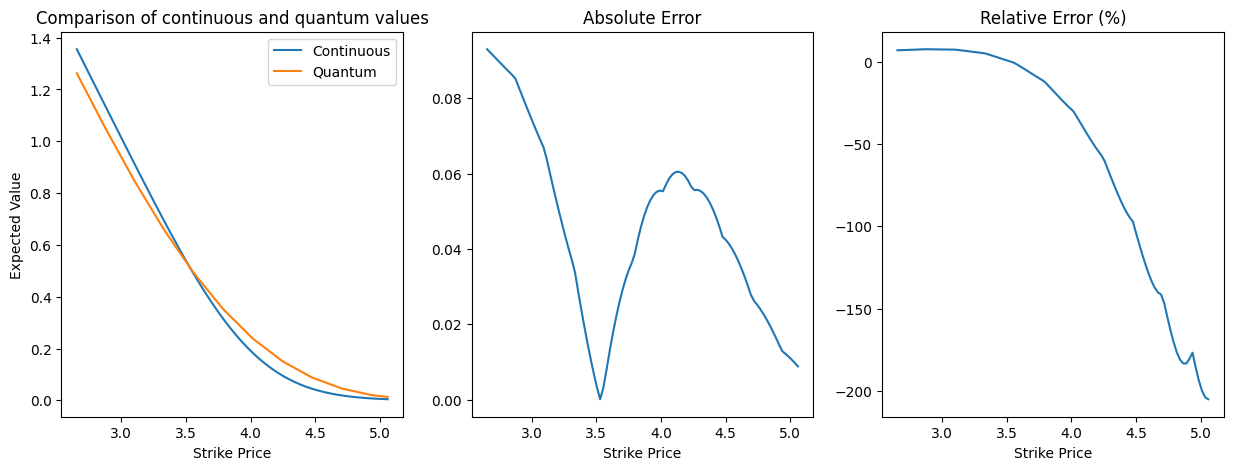

In [13]:
strike_prices = np.linspace(2*low[0]*1.1, 2*high[0]*0.9, 100)
exact_values = [expected_value_basket_call(asset1_params, asset2_params, covariance_matrix, K) for K in strike_prices]
discrete_values = [compute_discrete_expected_value(uncertainty_model, K) for K in strike_prices]

absolute_errors = [np.abs(exact_values[i] - discrete_values[i]) for i in range(len(strike_prices))]
relative_errors = [(1 - discrete_values[i] / exact_values[i])*100 for i in range(len(strike_prices))]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].plot(strike_prices, exact_values, label='Continuous')
ax[0].plot(strike_prices, discrete_values, label='Quantum')
ax[0].set_title('Comparison of continuous and quantum values')
ax[0].set_xlabel('Strike Price')
ax[0].set_ylabel('Expected Value')
ax[0].legend()

ax[1].plot(strike_prices, absolute_errors, label='absolute error')
ax[1].set_title('Absolute Error')
ax[1].set_xlabel('Strike Price')

ax[2].plot(strike_prices, relative_errors, label='relative error')
ax[2].set_title('Relative Error (%)')
ax[2].set_xlabel('Strike Price')

# Call-on-max Options
$payoff(x_1, x_2) = \max(x_1-\kappa, x_2-\kappa, 0)$

In [14]:
import numpy as np
from qfinance.option_pricing import OptionPricing, OptionParams
## define options
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 4

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

strike_price = 1.9

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = generate_covariance_matrix(variance, variance) # covariance matrix

# construct circuit
uncertainty_model = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))


discrete_expected_value = 0
for i in range(len(uncertainty_model.probabilities)):
    discrete_expected_value += max(0, max(uncertainty_model.values[i][0], uncertainty_model.values[i][1]) - strike_price) * uncertainty_model.probabilities[i]


def compute_discrete_expected_value(uncertainty_model, strike_price):
    discrete_expected_value = 0
    for i in range(len(uncertainty_model.probabilities)):
        discrete_expected_value += max(0, max(uncertainty_model.values[i][0], uncertainty_model.values[i][1]) - strike_price) * uncertainty_model.probabilities[i]
    return discrete_expected_value

In [19]:
def expected_value_call_on_max(asset1_params, asset2_params, covariance_matrix, K, n_simulations=100000):
    """
    Calculate the expected value of a basket call option using Monte Carlo simulation.

    Parameters:
    - asset1_params: dict with 'S', 'vol', 'r', 'T' for the first asset.
    - asset2_params: dict with 'S', 'vol', 'r', 'T' for the second asset.
    - covariance_matrix: 2x2 matrix representing the covariance between the assets.
    - K: Strike price of the basket call option.
    - n_simulations: Number of simulations to run (default is 100,000).

    Returns:
    - Expected value of the basket call option's payoff.
    """
    np.random.seed(0)  # For reproducibility
    
    # Unpack parameters
    S1, vol1, r1, T1 = asset1_params['S'], asset1_params['vol'], asset1_params['r'], asset1_params['T']
    S2, vol2, r2, T2 = asset2_params['S'], asset2_params['vol'], asset2_params['r'], asset2_params['T']
    
    # Ensure same r and T for both assets (for simplicity)
    r, T = r1, T1
    
    # Generate random numbers with the given covariance
    z = np.random.multivariate_normal([0, 0], covariance_matrix, size=n_simulations)
    
    # Simulate future values for both assets
    x1_T = S1 * np.exp((r - 0.5 * vol1**2) * T + vol1 * np.sqrt(T) * z[:, 0])
    x2_T = S2 * np.exp((r - 0.5 * vol2**2) * T + vol2 * np.sqrt(T) * z[:, 1])
    
    # Compute payoffs for each simulation
    payoffs = np.maximum(np.maximum(x1_T, x2_T) - K, 0)
    
    # Compute the expected payoff and discount it back to present value
    expected_value = np.mean(payoffs) * np.exp(-r * T)
    
    return expected_value

# Example parameters and covariance matrix
asset1_params = {'S': 2.0, 'vol': 0.4, 'r': 0.04, 'T': 40/365}
asset2_params = {'S': 2.0, 'vol': 0.4, 'r': 0.04, 'T': 40/365}
covariance_matrix = cov/variance  # Example covariance matrix


# Calculate the expected value of the basket call
expected_value = expected_value_call_on_max(asset1_params, asset2_params, covariance_matrix, strike_price)
print(f"Exact Expected value: {expected_value}")
print(f"Discrete Expected value: {discrete_expected_value}")
print(f"Relative error: {(1 - discrete_expected_value / expected_value) * 100} %")

Exact Expected value: 0.23846405894150358
Discrete Expected value: 0.30057655920471105
Relative error: -26.046902220365208 %


Text(0.5, 0, 'Strike Price')

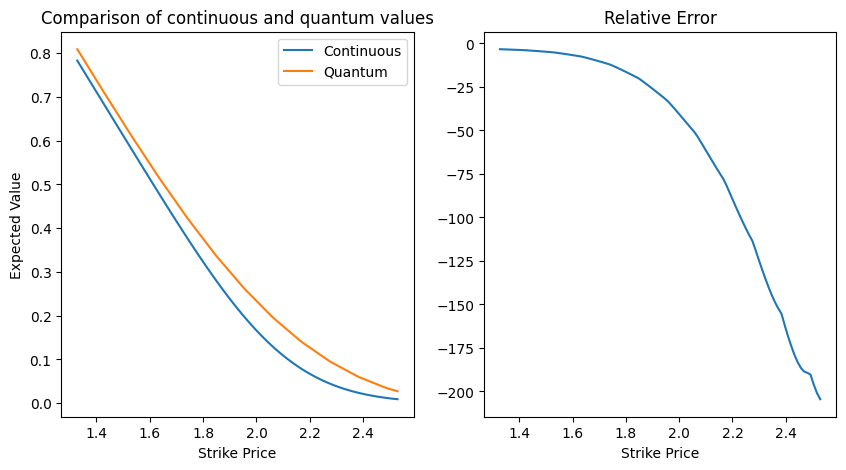

In [20]:
strike_prices = np.linspace(low[0]*1.1, high[0]*0.9, 100)
exact_values = [expected_value_call_on_max(asset1_params, asset2_params, covariance_matrix, K) for K in strike_prices]
discrete_values = [compute_discrete_expected_value(uncertainty_model, K) for K in strike_prices]

relative_errors = [(1 - discrete_values[i] / exact_values[i])*100 for i in range(len(strike_prices))]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(strike_prices, exact_values, label='Continuous')
ax[0].plot(strike_prices, discrete_values, label='Quantum')
ax[0].set_title('Comparison of continuous and quantum values')
ax[0].set_xlabel('Strike Price')
ax[0].set_ylabel('Expected Value')
ax[0].legend()

ax[1].plot(strike_prices, relative_errors, label='relative error')
ax[1].set_title('Relative Error')
ax[1].set_xlabel('Strike Price')

# Call-on-min options
$payoff(x_1, x_2) = max(\min(x_1, x_2) - \kappa, 0)$

In [21]:
import numpy as np
from qfinance.option_pricing import OptionPricing, OptionParams
## define options
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

strike_price = 1.7

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = generate_covariance_matrix(variance, variance) # covariance matrix

# construct circuit
uncertainty_model = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))


discrete_expected_value = 0
for i in range(len(uncertainty_model.probabilities)):
    discrete_expected_value += max(0, min(uncertainty_model.values[i][0], uncertainty_model.values[i][1]) - strike_price) * uncertainty_model.probabilities[i]
    
def compute_discrete_expected_value(uncertainty_model, strike_price):
    discrete_expected_value = 0
    for i in range(len(uncertainty_model.probabilities)):
        discrete_expected_value += max(0, min(uncertainty_model.values[i][0], uncertainty_model.values[i][1]) - strike_price) * uncertainty_model.probabilities[i]
    return discrete_expected_value

In [26]:
def expected_value_call_on_min(asset1_params, asset2_params, covariance_matrix, K, n_simulations=100000):
    """
    Calculate the expected value of a basket call option using Monte Carlo simulation.

    Parameters:
    - asset1_params: dict with 'S', 'vol', 'r', 'T' for the first asset.
    - asset2_params: dict with 'S', 'vol', 'r', 'T' for the second asset.
    - covariance_matrix: 2x2 matrix representing the covariance between the assets.
    - K: Strike price of the basket call option.
    - n_simulations: Number of simulations to run (default is 100,000).

    Returns:
    - Expected value of the basket call option's payoff.
    """
    np.random.seed(0)  # For reproducibility
    
    # Unpack parameters
    S1, vol1, r1, T1 = asset1_params['S'], asset1_params['vol'], asset1_params['r'], asset1_params['T']
    S2, vol2, r2, T2 = asset2_params['S'], asset2_params['vol'], asset2_params['r'], asset2_params['T']
    
    # Ensure same r and T for both assets (for simplicity)
    r, T = r1, T1
    
    # Generate random numbers with the given covariance
    z = np.random.multivariate_normal([0, 0], covariance_matrix, size=n_simulations)
    
    # Simulate future values for both assets
    x1_T = S1 * np.exp((r - 0.5 * vol1**2) * T + vol1 * np.sqrt(T) * z[:, 0])
    x2_T = S2 * np.exp((r - 0.5 * vol2**2) * T + vol2 * np.sqrt(T) * z[:, 1])
    
    # Compute payoffs for each simulation
    payoffs = np.maximum(np.minimum(x1_T, x2_T) - K, 0)
    
    # Compute the expected payoff and discount it back to present value
    expected_value = np.mean(payoffs) * np.exp(-r * T)
    
    return expected_value

# Example parameters and covariance matrix
asset1_params = {'S': 2.0, 'vol': 0.4, 'r': 0.04, 'T': 40/365}
asset2_params = {'S': 2.0, 'vol': 0.4, 'r': 0.04, 'T': 40/365}
covariance_matrix = cov/variance  # Example covariance matrix


# Calculate the expected value of the basket call
expected_value = expected_value_call_on_min(asset1_params, asset2_params, covariance_matrix, strike_price)
print(f"Exact Expected value: {expected_value}")
print(f"Discrete Expected value: {discrete_expected_value}")
print(f"Relative error: {(1 - discrete_expected_value / expected_value) * 100} %")

Exact Expected value: 0.22274187210920968
Discrete Expected value: 0.1836786862970558
Relative error: 17.53742367443213 %


Text(0.5, 0, 'Strike Price')

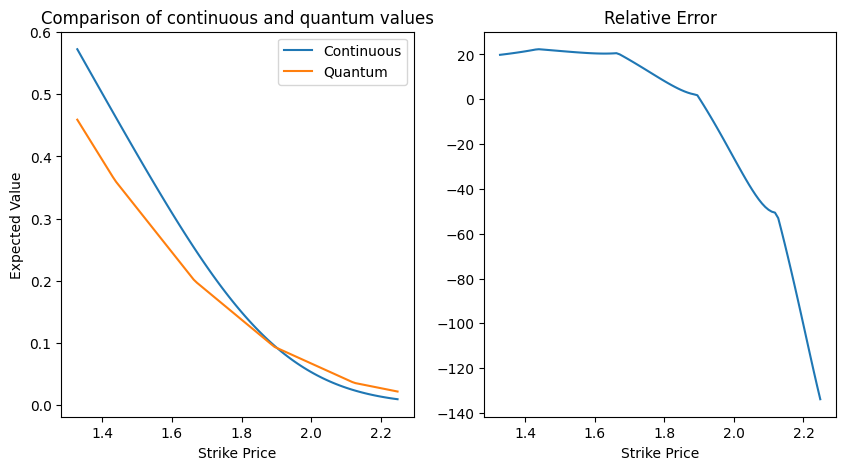

In [27]:
strike_prices = np.linspace(low[0]*1.1, high[0]*0.8, 100)
exact_values = [expected_value_call_on_min(asset1_params, asset2_params, covariance_matrix, K) for K in strike_prices]
discrete_values = [compute_discrete_expected_value(uncertainty_model, K) for K in strike_prices]

relative_errors = [(1 - discrete_values[i] / exact_values[i])*100 for i in range(len(strike_prices))]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(strike_prices, exact_values, label='Continuous')
ax[0].plot(strike_prices, discrete_values, label='Quantum')
ax[0].set_title('Comparison of continuous and quantum values')
ax[0].set_xlabel('Strike Price')
ax[0].set_ylabel('Expected Value')
ax[0].legend()

ax[1].plot(strike_prices, relative_errors, label='relative error')
ax[1].set_title('Relative Error')
ax[1].set_xlabel('Strike Price')

# Spread Call
$payoff = \max\{x_1 - x_2 -\kappa, 0\}$

In [28]:
import numpy as np
from qfinance.option_pricing import OptionPricing, OptionParams
## define options
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 5

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

strike_price = 0.2

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = generate_covariance_matrix(variance, variance, correlation=0.5) # covariance matrix

# construct circuit
uncertainty_model = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))


discrete_expected_value = 0
for i in range(len(uncertainty_model.probabilities)):
    discrete_expected_value += max(0, uncertainty_model.values[i][0] - uncertainty_model.values[i][1] - strike_price) * uncertainty_model.probabilities[i]
    
def compute_discrete_expected_value(uncertainty_model, strike_price):
    discrete_expected_value = 0
    for i in range(len(uncertainty_model.probabilities)):
        discrete_expected_value += max(0, uncertainty_model.values[i][0] - uncertainty_model.values[i][1] - strike_price) * uncertainty_model.probabilities[i]
    return discrete_expected_value

In [29]:
def expected_value_spread_call(asset1_params, asset2_params, covariance_matrix, K, n_simulations=100000):
    """
    Calculate the expected value of a basket call option using Monte Carlo simulation.

    Parameters:
    - asset1_params: dict with 'S', 'vol', 'r', 'T' for the first asset.
    - asset2_params: dict with 'S', 'vol', 'r', 'T' for the second asset.
    - covariance_matrix: 2x2 matrix representing the covariance between the assets.
    - K: Strike price of the basket call option.
    - n_simulations: Number of simulations to run (default is 100,000).

    Returns:
    - Expected value of the basket call option's payoff.
    """
    np.random.seed(0)  # For reproducibility
    
    # Unpack parameters
    S1, vol1, r1, T1 = asset1_params['S'], asset1_params['vol'], asset1_params['r'], asset1_params['T']
    S2, vol2, r2, T2 = asset2_params['S'], asset2_params['vol'], asset2_params['r'], asset2_params['T']
    
    # Ensure same r and T for both assets (for simplicity)
    r, T = r1, T1
    
    # Generate random numbers with the given covariance
    z = np.random.multivariate_normal([0, 0], covariance_matrix, size=n_simulations)
    
    # Simulate future values for both assets
    x1_T = S1 * np.exp((r - 0.5 * vol1**2) * T + vol1 * np.sqrt(T) * z[:, 0])
    x2_T = S2 * np.exp((r - 0.5 * vol2**2) * T + vol2 * np.sqrt(T) * z[:, 1])
    
    # Compute payoffs for each simulation
    payoffs = np.maximum(x1_T - x2_T - K, 0)
    
    # Compute the expected payoff and discount it back to present value
    expected_value = np.mean(payoffs) * np.exp(-r * T)
    
    return expected_value

# Example parameters and covariance matrix
asset1_params = {'S': 2.0, 'vol': 0.4, 'r': 0.04, 'T': 40/365}
asset2_params = {'S': 2.0, 'vol': 0.4, 'r': 0.04, 'T': 40/365}
covariance_matrix = cov/variance  # Example covariance matrix


# Calculate the expected value of the basket call
expected_value = expected_value_spread_call(asset1_params, asset2_params, covariance_matrix, strike_price)
print(f"Exact Expected value: {expected_value}")
print(f"Discrete Expected value: {discrete_expected_value}")
print(f"Relative error: {(1 - discrete_expected_value / expected_value) * 100} %")

Exact Expected value: 0.03451436692252122
Discrete Expected value: 0.09756899855629794
Relative error: -182.69096974985365 %


Text(0.5, 0, 'Strike Price')

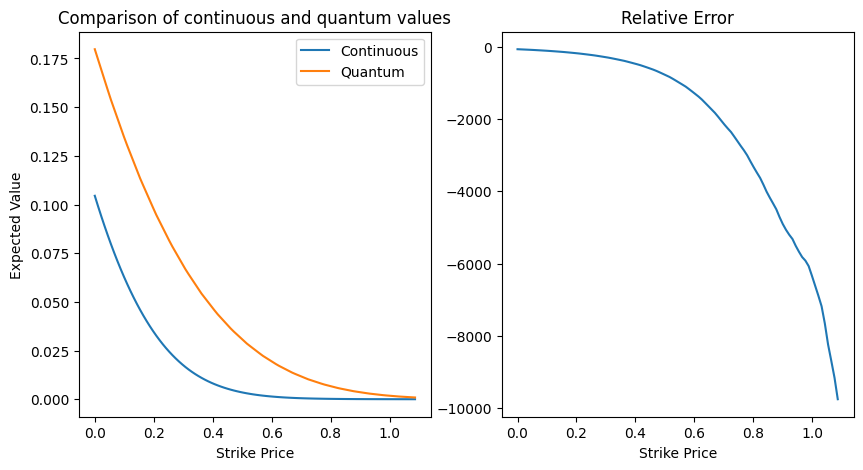

In [30]:
strike_prices = np.linspace(0, 0.9*low[0], 100)
exact_values = [expected_value_spread_call(asset1_params, asset2_params, covariance_matrix, K) for K in strike_prices]
discrete_values = [compute_discrete_expected_value(uncertainty_model, K) for K in strike_prices]

relative_errors = [(1 - discrete_values[i] / exact_values[i])*100 for i in range(len(strike_prices))]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(strike_prices, exact_values, label='Continuous')
ax[0].plot(strike_prices, discrete_values, label='Quantum')
ax[0].set_title('Comparison of continuous and quantum values')
ax[0].set_xlabel('Strike Price')
ax[0].set_ylabel('Expected Value')
ax[0].legend()

ax[1].plot(strike_prices, relative_errors, label='relative error')
ax[1].set_title('Relative Error')
ax[1].set_xlabel('Strike Price')

# Best-of-Call Options
$payoff(x_1,x_2) = \max(x_1-k_1, x_2-k_2, 0)$

In [33]:
import numpy as np
from qfinance.option_pricing import OptionPricing, OptionParams
## define options
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

strike_price_1 = 1.7
strike_price_2 = 1.9

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = generate_covariance_matrix(variance, variance, correlation=0.2) # covariance matrix

# construct circuit
uncertainty_model = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))


discrete_expected_value = 0
for i in range(len(uncertainty_model.probabilities)):
    discrete_expected_value += max(0, max(uncertainty_model.values[i][0] - strike_price_1, uncertainty_model.values[i][1] - strike_price_2)) * uncertainty_model.probabilities[i]
    
def compute_discrete_expected_value(uncertainty_model, strike_price_1, strike_price_2):
    discrete_expected_value = 0
    for i in range(len(uncertainty_model.probabilities)):
        discrete_expected_value += max(0, max(uncertainty_model.values[i][0] - strike_price_1, uncertainty_model.values[i][1] - strike_price_2)) * uncertainty_model.probabilities[i]
    return discrete_expected_value

In [34]:
def expected_value_best_of_call(asset1_params, asset2_params, covariance_matrix, K1, K2, n_simulations=100000):
    """
    Calculate the expected value of a basket call option using Monte Carlo simulation.

    Parameters:
    - asset1_params: dict with 'S', 'vol', 'r', 'T' for the first asset.
    - asset2_params: dict with 'S', 'vol', 'r', 'T' for the second asset.
    - covariance_matrix: 2x2 matrix representing the covariance between the assets.
    - K: Strike price of the basket call option.
    - n_simulations: Number of simulations to run (default is 100,000).

    Returns:
    - Expected value of the basket call option's payoff.
    """
    # np.random.seed(0)  # For reproducibility
    
    # Unpack parameters
    S1, vol1, r1, T1 = asset1_params['S'], asset1_params['vol'], asset1_params['r'], asset1_params['T']
    S2, vol2, r2, T2 = asset2_params['S'], asset2_params['vol'], asset2_params['r'], asset2_params['T']
    
    # Ensure same r and T for both assets (for simplicity)
    r, T = r1, T1
    
    # Generate random numbers with the given covariance
    z = np.random.multivariate_normal([0, 0], covariance_matrix, size=n_simulations)
    
    # Simulate future values for both assets
    x1_T = S1 * np.exp((r - 0.5 * vol1**2) * T + vol1 * np.sqrt(T) * z[:, 0])
    x2_T = S2 * np.exp((r - 0.5 * vol2**2) * T + vol2 * np.sqrt(T) * z[:, 1])
    
    # Compute payoffs for each simulation
    payoffs = np.maximum(np.maximum(x1_T -K1,x2_T - K2), 0)
    
    # Compute the expected payoff and discount it back to present value
    expected_value = np.mean(payoffs) * np.exp(-r * T)
    
    return expected_value

# Example parameters and covariance matrix
asset1_params = {'S': 2.0, 'vol': 0.4, 'r': 0.04, 'T': 40/365}
asset2_params = {'S': 2.0, 'vol': 0.4, 'r': 0.04, 'T': 40/365}
covariance_matrix = cov  # Example covariance matrix


# Calculate the expected value of the basket call
expected_value = expected_value_spread_call(asset1_params, asset2_params, covariance_matrix, strike_price_1, strike_price_2)
print(f"Exact Expected value: {expected_value}")
print(f"Discrete Expected value: {discrete_expected_value}")
print(f"Relative error: {(1 - discrete_expected_value / expected_value) * 100} %")

TypeError: 'float' object is unsliceable

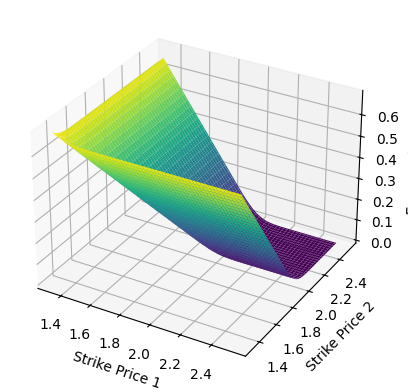

In [35]:
strike_prices = np.linspace(1.1*low[0], 0.9* high[0], 100)
exact_values = [expected_value_best_of_call(asset1_params, asset2_params, covariance_matrix, strike_price_1, strike_price_2) for strike_price_1 in strike_prices for strike_price_2 in strike_prices]
discrete_values = [compute_discrete_expected_value(uncertainty_model, strike_price_1, strike_price_2) for strike_price_1 in strike_prices for strike_price_2 in strike_prices]

relative_errors = [(1 - discrete_values[i] / exact_values[i])*100 for i in range(len(strike_prices))]

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

strike_1, strike_2 = np.meshgrid(strike_prices, strike_prices)
exact_values = np.array(exact_values).reshape(strike_1.shape)
discrete_values = np.array(discrete_values).reshape(strike_1.shape)

# Create a figure and a 3D subplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot a 3D surface
ax.plot_surface(strike_1, strike_2, exact_values, cmap='viridis')

# Customize the plot
ax.set_xlabel('Strike Price 1')
ax.set_ylabel('Strike Price 2')
ax.set_zlabel('Expected Value')

# Display the plot
plt.show()

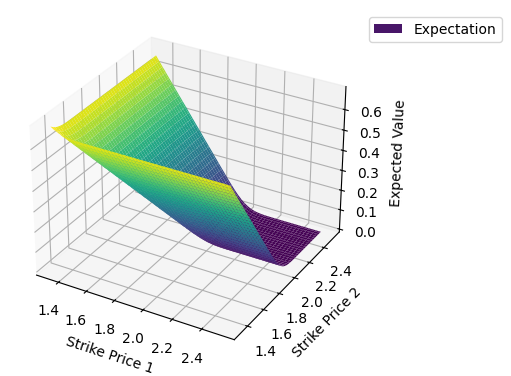

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

strike_1, strike_2 = np.meshgrid(strike_prices, strike_prices)
exact_values = np.array(exact_values).reshape(strike_1.shape)
discrete_values = np.array(discrete_values).reshape(strike_1.shape)

# Create a figure and a 3D subplot
fig = plt.figure(figsize=(5,10), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

# Plot a 3D surface
ax.plot_surface(strike_1, strike_2, exact_values, cmap='viridis', label="Expectation")

# Customize the plot
ax.set_xlabel('Strike Price 1')
ax.set_ylabel('Strike Price 2')
ax.set_zlabel('Expected Value')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust the location as needed

# Display the plot
plt.show()